In [1]:
import numpy as np
import rerun as rr
import laspy
import os
import open3d as o3d
import matplotlib.pyplot as plt
from collections import Counter



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
input_file = os.path.join('..', 'data', 'bws_250.LAZ')

# Open and read the LAS file
with laspy.open(input_file) as f:
    original_las = f.read()
  
    print("Point Attributes:")
    # Set column width
    col_width = 25  # Adjust this value for better spacing

    for dimension in f.header.point_format.dimension_names:
        dtype = original_las[dimension].dtype
        print(f"{dimension.ljust(col_width)} {str(dtype).ljust(col_width)}")

Point Attributes:
X                         int32                    
Y                         int32                    
Z                         int32                    
intensity                 uint16                   
return_number             uint8                    
number_of_returns         uint8                    
synthetic                 uint8                    
key_point                 uint8                    
withheld                  uint8                    
overlap                   uint8                    
scanner_channel           uint8                    
scan_direction_flag       uint8                    
edge_of_flight_line       uint8                    
classification            uint8                    
user_data                 uint8                    
scan_angle                int16                    
point_source_id           uint16                   
gps_time                  float64                  
red                       uint16              

In [3]:
#function to get the ndvi values
def get_ndvi(red, nir):
    red = np.array(red, dtype=np.float64)
    nir = np.array(nir, dtype=np.float64)

    red = red / 65535 #red is 16bits encoded
    nir = nir / 255 #nir is 8bits encoded (but still an uint16)

    return (nir - red) / (nir+ red + 1e-8)

In [4]:
#calculate ndvi and add it to the las attributes
#overwrite potentially existing ndvi

if 'ndvi' not in original_las.point_format.dimension_names:
    original_las.add_extra_dim(laspy.ExtraBytesParams(name='ndvi', type=np.float32))

# Assign the NDVI values
original_las.ndvi = get_ndvi(original_las.red, original_las.nir)

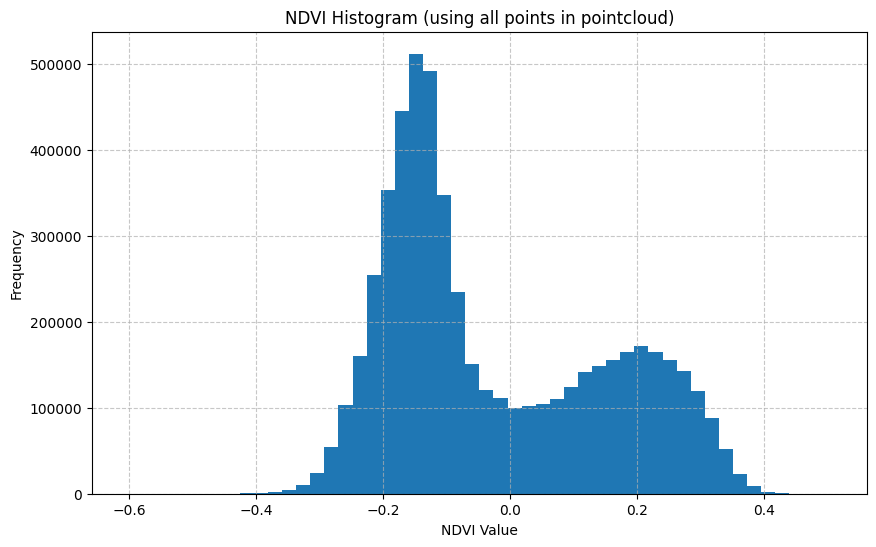

 min ndvi value: -0.6034130454063416
 max ndvi value: 0.5067505240440369


In [5]:
def plot_ndvi_histogram(ndvi_values):
    """Plot a histogram of NDVI values."""
    plt.figure(figsize=(10, 6))
    plt.hist(ndvi_values, bins=50)#, linewidth=.5, edgecolor='black')
    plt.title("NDVI Histogram (using all points in pointcloud)")
    plt.xlabel("NDVI Value")
    plt.ylabel("Frequency")
    plt.grid(linestyle='--', alpha=0.7)
    plt.show()

plot_ndvi_histogram(original_las.ndvi)
print(f' min ndvi value: {min(original_las.ndvi)}')
print(f' max ndvi value: {max(original_las.ndvi)}')

In [6]:
# Mapping AHN classification codes to their meanings
AHN_classification_mapping = {
    0: "Created, never classified",
    1: "Unclassified",
    2: "Ground",
    6: "Building",
    9: "Water",
    14: "High tension",
    26: "Civil structure"
}

# Extract classification values from the LAS file
classification_values = original_las.classification

# Print unique classification values and their meanings
unique_values = np.unique(classification_values)
print("Unique Classification Values and Meanings:")
for value in unique_values:
    meaning = AHN_classification_mapping.get(value, "Unknown")  # Handle unknown classifications
    print(f"Class {value}:\t{meaning}")

# Count the occurrences of each classification
counts = Counter(classification_values)

# Sort the classifications by count in descending order
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

# Display the classification counts in a tabular format
print("\nClassification Counts (Ordered by Frequency):")

# Define column widths for alignment
class_col_width = 10  # Width for the 'Class' column
meaning_col_width = 25  # Width for the 'Meaning' column
count_col_width = 15  # Width for the 'Points' column

# Print header
print(f"{'Class'.ljust(class_col_width)} {'Meaning'.ljust(meaning_col_width)} {'Points'.rjust(count_col_width)}")
print("-" * (class_col_width + meaning_col_width + count_col_width + 5))

# Print the counts for each classification
for cls, count in sorted_counts:
    meaning = AHN_classification_mapping.get(cls, "Unknown")
    print(f"{str(cls).ljust(class_col_width)} {meaning.ljust(meaning_col_width)} {str(count).rjust(count_col_width)}")


Unique Classification Values and Meanings:
Class 1:	Unclassified
Class 2:	Ground
Class 6:	Building
Class 9:	Water
Class 26:	Civil structure

Classification Counts (Ordered by Frequency):
Class      Meaning                            Points
-------------------------------------------------------
2          Ground                            1998448
1          Unclassified                      1813593
6          Building                          1582864
26         Civil structure                     63761
9          Water                                 649


## Below the filtering of the pointcloud takes place

In [19]:
#create copy of las_original to perform filtering on the copy (called las for simplicity)
las = laspy.LasData(original_las.header)
las.points = original_las.points.copy()

In [20]:
#Filter to keep only Unclassified points
las = las[las.classification == 1]

#Filter out points with NDVI value under threshold
ndvi_threshold = 0
las = las[las.ndvi > ndvi_threshold]

#Remove points with single return
las = las[las.number_of_returns > 1]

#Remove last return of all remaining points
las = las[las.return_number != las.number_of_returns]


In [21]:
# Remove outliers using SOR
def remove_outliers(las_data, nb_neighbors=20, std_ratio=2.0):
    # Convert LAS data to Open3D point cloud
    xyz = np.vstack((las_data.x, las_data.y, las_data.z)).transpose()
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)

    # Perform statistical outlier removal
    cl, ind = pcd.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    
    # Filter the original LAS data
    filtered_las = las_data[ind]
    
    return filtered_las

# After your previous filtering steps:
las = remove_outliers(las, 20, 2.0)

In [22]:
def visualize_point_cloud_with_rerun(las_data):
    # Initialize rerun
    rr.init("LAS Point Cloud Viewer - NDVI, NIR, Red", spawn=True)

    # Check if red and nir bands exist
    if not (hasattr(las_data, 'red') and hasattr(las_data, 'nir')):
        raise ValueError("The LAS file does not contain 'red' and 'nir' bands required for NDVI calculation.")

    # Calculate NDVI
    ndvi = get_ndvi(las_data.red, las_data.nir)

    points = np.column_stack((las_data.x, las_data.y, las_data.z))
    ndvi_values = ndvi
    nir_values = las_data.nir
    red_values = las_data.red

    # Normalize NIR and Red values to 0-1 range     BTW this is max FOUND values not max possible
    nir_normalized = (nir_values - np.min(nir_values)) / (np.max(nir_values) - np.min(nir_values))
    red_normalized = (red_values - np.min(red_values)) / (np.max(red_values) - np.min(red_values))

    # Create color array: Red channel for Red values, Green for NDVI, Blue for NIR
    colors = np.column_stack((
        red_normalized,
        (ndvi_values + 1) / 2,  # NDVI is already in [-1, 1] range, normalize to [0, 1]
        nir_normalized
    ))

    # Log the point cloud to rerun
    rr.log("point_cloud", 
           rr.Points3D(
               positions=points,
               colors=colors,
               radii=.5,  # Adjust point size as needed
               labels=[f"NDVI: {ndvi:.3f}, NIR: {nir:.3f}, Red: {red:.3f}" 
                       for ndvi, nir, red in zip(ndvi_values, nir_values, red_values)]
           ))

    # Log some text to provide context
    rr.log("info", rr.TextLog("Point cloud: Red channel = Red band, Green channel = NDVI, Blue channel = NIR band. Hover for values."))

    print(f"Visualization ready. Run 'rerun' in terminal to view.")

In [ ]:
visualize_point_cloud_with_rerun(las)

Visualization ready. Run 'rerun' in terminal to view.


In [24]:
def visualize_point_cloud_with_rerun(las_data, las_original=None):
    # Initialize rerun
    rr.init("LAS Point Cloud Viewer - NDVI, NIR, Red", spawn=True)

    # Check if red and nir bands exist in the filtered point cloud
    if not (hasattr(las_data, 'red') and hasattr(las_data, 'nir')):
        raise ValueError("The LAS file does not contain 'red' and 'nir' bands required for NDVI calculation.")

    # Calculate NDVI for the filtered point cloud
    ndvi = get_ndvi(las_data.red, las_data.nir)
    points = np.column_stack((las_data.x, las_data.y, las_data.z))
    ndvi_values = ndvi
    nir_values = las_data.nir
    red_values = las_data.red

    # Normalize NIR and Red values to 0-1 range for the filtered point cloud
    nir_normalized = (nir_values - np.min(nir_values)) / (np.max(nir_values) - np.min(nir_values))
    red_normalized = (red_values - np.min(red_values)) / (np.max(red_values) - np.min(red_values))

    # Create color array for the filtered point cloud
    colors = np.column_stack((
        red_normalized,
        (ndvi_values + 1) / 2,  # NDVI is already in [-1, 1] range, normalize to [0, 1]
        nir_normalized
    ))

    # Log the filtered point cloud
    rr.log("filtered_point_cloud", 
           rr.Points3D(
               positions=points,
               colors=colors,
               radii=.5,  # Adjust point size as needed
               labels=[f"NDVI: {ndvi:.3f}, NIR: {nir:.3f}, Red: {red:.3f}" 
                       for ndvi, nir, red in zip(ndvi_values, nir_values, red_values)]
           ))

    # Include the original point cloud if provided
    if las_original is not None:
        # Check if red and nir bands exist in the original point cloud
        if not (hasattr(las_original, 'red') and hasattr(las_original, 'nir')):
            raise ValueError("The original LAS file does not contain 'red' and 'nir' bands required for NDVI calculation.")

        # Calculate NDVI for the original point cloud
        ndvi_original = get_ndvi(las_original.red, las_original.nir)
        points_original = np.column_stack((las_original.x, las_original.y, las_original.z))
        nir_original = las_original.nir
        red_original = las_original.red

        # Normalize NIR and Red values for the original point cloud
        nir_original_normalized = (nir_original - np.min(nir_original)) / (np.max(nir_original) - np.min(nir_original))
        red_original_normalized = (red_original - np.min(red_original)) / (np.max(red_original) - np.min(red_original))

        # Create color array for the original point cloud
        colors_original = np.column_stack((
            red_original_normalized,
            (ndvi_original + 1) / 2,  # NDVI is already in [-1, 1] range, normalize to [0, 1]
            nir_original_normalized
        ))

        # Log the original point cloud
        rr.log("original_point_cloud", 
               rr.Points3D(
                   positions=points_original,
                   colors=colors_original,
                   radii=.5,  # Adjust point size as needed
                   labels=[f"NDVI: {ndvi:.3f}, NIR: {nir:.3f}, Red: {red:.3f}" 
                           for ndvi, nir, red in zip(ndvi_original, nir_original, red_original)]
               ))

    # Log some text to provide context
    rr.log("info", rr.TextLog("Point cloud: Red channel = Red band, Green channel = NDVI, Blue channel = NIR band. Hover for values."))

    print(f"Visualization ready. Run 'rerun' in terminal to view.")


In [ ]:
visualize_point_cloud_with_rerun(las, original_las)